
  ****READING THE DATA


In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
# For data splitting and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight







# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [95]:
x = r"C:\Users\zaxak\Desktop\Train.csv"
df = pd.read_csv(x)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


>DATA CLEAN




FEATURE ENGINEERING

In [96]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())


  Warehouse_block Mode_of_Shipment Product_importance Gender
0               D           Flight                low      F
1               F           Flight                low      M
2               A           Flight                low      M
3               B           Flight             medium      M
4               C           Flight             medium      F
   Warehouse_block  Mode_of_Shipment  Product_importance  Gender
0                3                 0                   1       0
1                4                 0                   1       1
2                0                 0                   1       1
3                1                 0                   2       1
4                2                 0                   2       0


*iqr xxoris kai columnskai ade EXPERIMENT



In [97]:
# Feature 1: Discount as a Ratio of Product Cost
df['Discount_as_Ratio'] = df['Discount_offered'] / df['Cost_of_the_Product']

# Feature 2: Customer Engagement Ratio (Care per Purchase)
df['Care_per_Purchase'] = df['Customer_care_calls'] / (df['Prior_purchases'] + 1e-6)

# Feature 3: Product Value Density (Cost per Gram)
# Uses a small value in the denominator to prevent division by zero, though weight is unlikely to be 0.
df['Value_Density'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1e-6)

# Feature 4: Effective Purchase Rating
# Uses natural log (log) of (Prior_purchases + 1) to dampen the effect of high purchase counts.
df['Effective_Rating'] = df['Customer_rating'] * np.log(df['Prior_purchases'] + 1)

# Identify all numerical and the newly created combination columns
cols_to_keep = [ 
     'Discount_offered', 'Weight_in_gms', 
    'Reached.on.Time_Y.N','Product_importance','Discount_as_Ratio','Care_per_Purchase','Value_Density','Effective_Rating'
]
# Create the final DataFrame with only numerical columns
df = df[cols_to_keep].copy()
df = df.rename(columns={'Reached.on.Time_Y.N': 'Target_On_Time'})

# Display the first few rows showing the new features
print("DataFrame with four new numerical combinations:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

DataFrame with four new numerical combinations:
| Discount_offered   | Weight_in_gms   | Target_On_Time   | Product_importance   | Discount_as_Ratio   | Care_per_Purchase   | Value_Density   | Effective_Rating   |
|:-------------------|:----------------|:-----------------|:---------------------|:--------------------|:--------------------|:----------------|:-------------------|
| 44                 | 1233            | 1                | 1                    | 0.248588            | 1.33333             | 0.143552        | 2.77259            |
| 59                 | 3088            | 1                | 1                    | 0.273148            | 2                   | 0.0699482       | 5.49306            |
| 48                 | 3374            | 1                | 1                    | 0.262295            | 0.5                 | 0.0542383       | 3.21888            |
| 10                 | 1177            | 1                | 2                    | 0.0568182           | 0.75             

DATA SPLIT

In [98]:
# Target variable (y): Select the column you want to predict
y = df['Target_On_Time']

# Features (X): Select all other columns by dropping the target variable
X = df.drop('Target_On_Time', axis=1)

In [99]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [100]:
from sklearn.preprocessing import StandardScaler

# 1. CRITICAL: SAVE the original column names BEFORE scaling
original_columns = X_train.columns

scaler = StandardScaler()

# 2. Fit and transform the training data
# This results in a NumPy array.
X_train_scaled_array = scaler.fit_transform(X_train)

# 3. Convert the scaled array back to a DataFrame, 
#    re-applying the original column names
X_train = pd.DataFrame(X_train_scaled_array, columns=original_columns)

# 4. Transform X_test using the same fitted scaler
X_test_scaled_array = scaler.transform(X_test)

# 5. Convert X_test back to a DataFrame (assuming X_test also needs column names)
#    Note: X_test's original columns should be the same as X_train's
X_test = pd.DataFrame(X_test_scaled_array, columns=original_columns)

# X_train and X_test are now scaled DataFrames with their column names intact.


****MODEL CREATION*******

In [42]:
#RANDOM FOREST CLASSIFIER


rf_model = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)
y_probalities_RF = rf_model.predict_proba(X_test)
y_probs_rf = y_probalities_RF[:, 1]


In [43]:
print('accuracy:',accuracy_score(y_test,rf_predictions))
print('f1:',f1_score(y_test,rf_predictions))
print(confusion_matrix(y_test,rf_predictions))
print('recall:',recall_score(y_test,rf_predictions))
print('precision:',precision_score(y_test,rf_predictions))
print('auc:',roc_auc_score(y_test,y_probs_rf))

accuracy: 0.6518181818181819
f1: 0.6792294807370184
[[623 264]
 [502 811]]
recall: 0.6176694592536177
precision: 0.7544186046511628
auc: 0.7298642230886864


In [44]:
#SVM
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)

# Get predictions and probabilities
svc_predictions = svc_model.predict(X_test)
svc_probabilities = svc_model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

# Evaluate Baseline Performance
print("--- SVC BASELINE METRICS (Default Settings) ---")
print('Accuracy:', accuracy_score(y_test, svc_predictions))
print('F1:', f1_score(y_test, svc_predictions))
print('AUC:', roc_auc_score(y_test, svc_probabilities))
print('Confusion Matrix:\n', confusion_matrix(y_test, svc_predictions))
print('Recall:', recall_score(y_test, svc_predictions))
print('Precicion:',precision_score(y_test, svc_predictions))

--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.6745454545454546
F1: 0.6507317073170732
AUC: 0.7599428488508377
Confusion Matrix:
 [[817  70]
 [646 667]]
Recall: 0.507996953541508
Precicion: 0.9050203527815468


In [45]:
#LOGISTIC REGRESIION
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(X_train,y_train)
log_preds=log_reg.predict(X_test)
y_probalities_log = log_reg.predict_proba(X_test)
y_probs_log = y_probalities_log[:, 1]


In [46]:
print('accuracy:',accuracy_score(y_test,log_preds))
print('f1:',f1_score(y_test,log_preds))
print(confusion_matrix(y_test,log_preds))
print('recall:',recall_score(y_test,log_preds))
print('precision:',precision_score(y_test,log_preds))
print('auc:',roc_auc_score(y_test,y_probs_log))

accuracy: 0.6604545454545454
f1: 0.7069438995684583
[[552 335]
 [412 901]]
recall: 0.6862147753236862
precision: 0.7289644012944984
auc: 0.735048268507364


In [47]:
#KNN
import matplotlib.pyplot as plt
from sklearn.neighbors  import KNeighborsClassifier


	# Set up a KNN Classifier
knn = KNeighborsClassifier().fit(X_train,y_train)
  #  accuracy
knn_predicts=knn.predict(X_test)
y_probalities_knn = knn.predict_proba(X_test)
y_probs_knn = y_probalities_knn[:, 1]




In [48]:
print('accuracy:',accuracy_score(y_test,knn_predicts))
print('f1:',f1_score(y_test,knn_predicts))
print(confusion_matrix(y_test,knn_predicts))
print('recall:',recall_score(y_test,knn_predicts))
print('precision:',precision_score(y_test,knn_predicts))
print('auc:',roc_auc_score(y_test,y_probs_knn))

accuracy: 0.6318181818181818
f1: 0.6701954397394136
[[567 320]
 [490 823]]
recall: 0.6268088347296268
precision: 0.7200349956255468
auc: 0.707581199538738


In [49]:
#DECISION TREE


Dec_Tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
predictions=Dec_Tree.predict(X_test)
y_probalities_dec = Dec_Tree.predict_proba(X_test)
y_probs_dec = y_probalities_dec[:, 1]



In [50]:
print('accuracy:',accuracy_score(y_test,predictions))
print('f1:',f1_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print('recall:',recall_score(y_test,predictions))
print('precision:',precision_score(y_test,predictions))
print('auc:',roc_auc_score(y_test,y_probs_dec))

accuracy: 0.6386363636363637
f1: 0.6929316338354577
[[508 379]
 [416 897]]
recall: 0.6831683168316832
precision: 0.7029780564263323
auc: 0.6279426702534967


In [51]:
#XGBOOST
from xgboost import XGBClassifier
Xgboost=XGBClassifier(random_state=42).fit(X_train,y_train)
Xg_preds=Xgboost.predict(X_test)
y_probalities_xg = Xgboost.predict_proba(X_test)
y_probs_xg = y_probalities_xg[:, 1]


In [52]:
print('accuracy:',accuracy_score(y_test,Xg_preds))
print('f1:',f1_score(y_test,Xg_preds))
print(confusion_matrix(y_test,Xg_preds))
print('recall:',recall_score(y_test,Xg_preds))
print('precision:',precision_score(y_test,Xg_preds))
print('auc:',roc_auc_score(y_test,y_probs_xg))

accuracy: 0.6613636363636364
f1: 0.6942962659006976
[[609 278]
 [467 846]]
recall: 0.6443259710586443
precision: 0.7526690391459074
auc: 0.743906009714665


#*****************HYPERPARAMETERS

In [53]:
#What are the hyperparameters for each model ?
#KNN
print('KNN:',knn.get_params().keys())
#RANDOM FOREST CLASSIFIER
print('Random Forest:',rf_model.get_params().keys())
print('Decision Tree:',Dec_Tree.get_params().keys())
print('Xgboost',Xgboost.get_params().keys())
print('Logistic regression:',log_reg.get_params().keys())
print('SVM:',svc_model.get_params().keys())

KNN: dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
Xgboost dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_cons

DECISION TREE TUNING


In [54]:
#GRIDSEARCH FOR DECICION TREE
param_grid_DCT={'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'splitter' : ["best", "random"],
               'min_samples_split' : [2,5,10,20],
               'min_samples_leaf' : [1,5,10,20],
            'class_weight': [None,'balanced',{0: 1, 1: 5},{0: 1, 1: 10} ],}
                
grid_DCT=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_DCT,cv=5,n_jobs=-1,scoring='roc_auc')
grid_DCT.fit(X_train,y_train)
grid_DCT.best_params_


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}

In [55]:
#More Decicision Tree Hyperparameters to tune
param_grid_DCT2={'min_weight_fraction_leaf': [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
            'max_features': ['sqrt', 'log2'],
            'max_leaf_nodes': [5, 10, 25, 50, 100, 200, None],
            'min_impurity_decrease': [0.0, 0.001, 0.01, 0.05, 0.1, 0.2],
'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]}
grid_DCT2=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid_DCT2,cv=5,n_jobs=-1,scoring='roc_auc')
grid_DCT2.fit(X_train,y_train)
grid_DCT2.best_params_

{'ccp_alpha': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.0,
 'min_weight_fraction_leaf': 0.001}

In [56]:
best_params = {
 'class_weight': {0: 1, 1: 10},
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 20,
}
Dec_Tree_tuned=DecisionTreeClassifier(**best_params,random_state=42) 
Dec_Tree_tuned.fit(X_train,y_train)
predict=Dec_Tree_tuned.predict(X_test)

y_proba_all_dec = Dec_Tree_tuned.predict_proba(X_test)
y_scores_dec = y_proba_all_dec[:, 1]


In [57]:
print('accuracy:',accuracy_score(y_test,predict))
print('f1:',f1_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print('recall:',recall_score(y_test,predict))
print('precision:',precision_score(y_test,predict))
print('AUC',roc_auc_score(y_test,y_scores_dec))

accuracy: 0.5986363636363636
f1: 0.7466284074605452
[[  16  871]
 [  12 1301]]
recall: 0.9908606245239908
precision: 0.598987108655617
AUC 0.7209176125313512


*KNN TUNING and complexity visualization


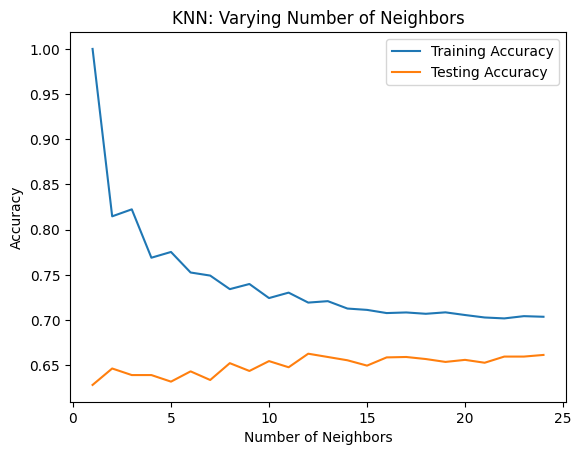

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {np.int64(1): 1.0, np.int64(2): 0.8147516763268553, np.int64(3): 0.822479827253097, np.int64(4): 0.768951017161041, np.int64(5): 0.7753153767473576, np.int64(6): 0.7525855210819411, np.int64(7): 0.7491760427321287, np.int64(8): 0.7341743379929537, np.int64(9): 0.7398568019093079, np.int64(10): 0.7242868507784975, np.int64(11): 0.7303102625298329, np.int64(12): 0.7192862825321059, np.int64(13): 0.7208773724286851, np.int64(14): 0.7126946243891351, np.int64(15): 0.711217183770883, np.int64(16): 0.7076940561427435, np.int64(17): 0.708375951812706, np.int64(18): 0.7068985111944539, np.int64(19): 0.7084896010910331, np.int64(20): 0.7055347198545289, np.int64(21): 0.7028071371746789, np.int64(22): 0.7017842936697352, np.int64(23): 0.704284577792931, np.int64(24): 0.7036026821229685} 
 {np.int64(1): 0.6281818181818182, np.int64(2): 0.6463636363636364, np.int64(3): 0.639090909090909, np.int64(4): 0.639090909090909, np.

In [58]:
neighbors = np.arange(1, 25)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor).fit(X_train,y_train)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)


# PLOT MODEL COMPLEXITY
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)


In [59]:
# Find the key corresponding to the maximum value
best_key = max(test_accuracies, key=test_accuracies.get)
best_value = test_accuracies[best_key]

print(f"K={best_key} is the best value for the hyperparameter 'n_neighbors', to maximize accuracy ")
print(f"Highest value: {best_value:.4f}")


K=12 is the best value for the hyperparameter 'n_neighbors', to maximize accuracy 
Highest value: 0.6627


In [60]:
#More KNN hyperparameters to tune
param_grid_KNN={'n_neighbors': range(1,26),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20,30,40],
'p': [1,2],
'metric' : ['minkowski','manhattan'],
}
grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid_KNN,cv=5,n_jobs=-1,scoring='roc_auc')
grid_knn.fit(X_train,y_train)
grid_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 21,
 'p': 1,
 'weights': 'distance'}

In [61]:
best_knn_params={'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 16,
 'p': 1,
 'weights': 'uniform',
 'n_jobs': -1}
Tuned_KNN=KNeighborsClassifier(**best_knn_params)
Tuned_KNN.fit(X_train,y_train)
KNN_predictionS=Tuned_KNN.predict(X_test)
y_proba_all_KNN = Tuned_KNN.predict_proba(X_test)
y_scores_KNN = y_proba_all_KNN[:, 1]

In [62]:
print('accuracy:',accuracy_score(y_test,KNN_predictionS))
print('f1:',f1_score(y_test,KNN_predictionS))
print(confusion_matrix(y_test,KNN_predictionS))
print('recall:',recall_score(y_test,KNN_predictionS))
print('precision:',precision_score(y_test,KNN_predictionS))
print('AUC',roc_auc_score(y_test,y_scores_KNN))

accuracy: 0.6513636363636364
f1: 0.6574363555158553
[[697 190]
 [577 736]]
recall: 0.5605483625285606
precision: 0.7948164146868251
AUC 0.7194793887506


**RANDOMFOREST TUNE


In [136]:
# RANDOM FOREST TUNIN

param_grid_RF = {'n_estimators': range(10, 50, 10),
              'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'bootstrap' : [True, False],
               'min_samples_split' : [2,5,10,20],
               'min_samples_leaf' : [1,5,10,20],
               'max_features':['sqrt', 'log2',0.5,0.8],
               'class_weight': ['balanced', 'balanced_subsample','None'],
               'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1],
               'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01, 0.1]
            }

random_search_RF = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_grid_RF,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # Set a random state for reproducibility
)
random_search_RF.fit(X_train, y_train)

print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_RF.best_params_)
print("\n--- RandomizedSearchCV Best Score (Average CV Accuracy) ---")
print(f"{random_search_RF.best_score_:.4f}")

--- RandomizedSearchCV Best Parameters ---
{'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': False}

--- RandomizedSearchCV Best Score (Average CV Accuracy) ---
0.6856


c:\Users\zaxak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\zaxak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zaxak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\

In [137]:
best_rf_params={'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_features': 0.5, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'ccp_alpha': 0.0, 'bootstrap': False}


Tuned_RF=RandomForestClassifier(**best_rf_params,random_state=42,n_jobs=-1)
Tuned_RF.fit(X_train,y_train)
rf_tuned_predictions=Tuned_RF.predict(X_test)
y_proba_all_RF = Tuned_RF.predict_proba(X_test)
y_scores_RF = y_proba_all_RF[:, 1]




In [138]:
print('accuracy:',accuracy_score(y_test,rf_tuned_predictions))
print('f1:',f1_score(y_test,rf_tuned_predictions))
print(confusion_matrix(y_test,rf_tuned_predictions))
print('recall:',recall_score(y_test,rf_tuned_predictions))
print('precision:',precision_score(y_test,rf_tuned_predictions))

print('AUC',roc_auc_score(y_test,y_scores_RF))


accuracy: 0.6759090909090909
f1: 0.6330416881111683
[[872  15]
 [698 615]]
recall: 0.4683929931454684
precision: 0.9761904761904762
AUC 0.7528144107446908


*LOG REGRESSION TUNE


In [66]:
param_grid_lg ={
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
   
   
grid_search_lg = GridSearchCV(LogisticRegression(solver='liblinear'),
    param_grid_lg,
    scoring='roc_auc',
    cv=5,                 # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available CPU cores
)
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

In [67]:
lg_best={'C': 100, 'max_iter': 1000, 'penalty': 'l1'}
Tuned_lg=LogisticRegression(**lg_best,random_state=42,solver='saga')
Tuned_lg.fit(X_train,y_train)
LG_tuned_predictions=Tuned_lg.predict(X_test)
y_proba_all_lg = Tuned_lg.predict_proba(X_test)
y_scores_lg = y_proba_all_lg[:, 1]


In [68]:
print(confusion_matrix(y_test,LG_tuned_predictions))
print('PRECICION:',precision_score(y_test,LG_tuned_predictions))
print('f1:',f1_score(y_test,LG_tuned_predictions))
print('recall',recall_score(y_test,LG_tuned_predictions))
print('accuracy',accuracy_score(y_test,LG_tuned_predictions))
y=roc_auc_score(y_test,y_scores_lg)
print('AUC',y)

[[550 337]
 [412 901]]
PRECICION: 0.7277867528271406
f1: 0.706389651117209
recall 0.6862147753236862
accuracy 0.6595454545454545
AUC 0.7351238289209201


****SVM TUNE

In [69]:

param_grid_SVC = {
    'C': [0.1, 1, 10],            
    'kernel': ['rbf', 'poly'],    
    'gamma': ['scale', 'auto']    
}


grid_SVC = GridSearchCV(
    SVC(random_state=42, probability=True), 
    param_grid_SVC, 
    cv=5,                      
    n_jobs=-1,                 
    scoring='roc_auc'  # Optimizing for Area Under the ROC Curve
)

grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_





{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [70]:
svm_best={'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Tuned_svm=SVC(**svm_best,random_state=42,probability=True)
Tuned_svm.fit(X_train,y_train)
SVM_tuned_predictions=Tuned_svm.predict(X_test)
y_proba_all_svm1 = Tuned_svm.predict_proba(X_test)
y_scores_svm1 = y_proba_all_svm1[:, 1]

In [71]:
print(confusion_matrix(y_test,SVM_tuned_predictions))
print('PRECICION:',precision_score(y_test,SVM_tuned_predictions))
print('f1:',f1_score(y_test,SVM_tuned_predictions))
print('recall',recall_score(y_test,SVM_tuned_predictions))
print('accuracy',accuracy_score(y_test,SVM_tuned_predictions))
y=roc_auc_score(y_test,y_scores_svm1)
print('AUC',y)

[[784 103]
 [610 703]]
PRECICION: 0.8722084367245657
f1: 0.6635205285512034
recall 0.5354150799695354
accuracy 0.6759090909090909
AUC 0.7579808540215742



***XGBOOST TUNE


In [141]:
from sklearn.model_selection import RandomizedSearchCV 
param_grid_XG = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma':[0, 0.1, 0.2],
        'min_child_weight':[1, 3, 5, 7],
        'grow_policy':['depthwise','lossguide'],
        'booster':['gbtree','gblinear','dart'],
        'scale_pos_weight': [1, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0]
        }
random_search_XG = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'), # XGBoost setup
    param_distributions=param_grid_XG,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 # Set a random state for reproducibility
)
random_search_XG.fit(X_train, y_train)

print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_XG.best_params_)
print("\n--- RandomizedSearchCV Best Score (Average CV Accuracy) ---")
print(f"{random_search_XG.best_score_:.4f}")

--- RandomizedSearchCV Best Parameters ---
{'subsample': 0.7, 'scale_pos_weight': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

--- RandomizedSearchCV Best Score (Average CV Accuracy) ---
0.6721


In [142]:

xg_best={'subsample': 0.7, 'scale_pos_weight': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

Tuned_xg=XGBClassifier(**xg_best,random_state=42,n_jobs=-1,eval_metric="auc")
  # metric to track
Tuned_xg.fit(X_train,y_train)
XG_tuned_predictions=Tuned_xg.predict(X_test)
y_proba_all = Tuned_xg.predict_proba(X_test)
y_scores = y_proba_all[:, 1]


In [143]:
print(confusion_matrix(y_test,XG_tuned_predictions))
print('PRECICION:',precision_score(y_test,XG_tuned_predictions))
print('f1:',f1_score(y_test,XG_tuned_predictions))
print('recall',recall_score(y_test,XG_tuned_predictions))
print('accuracy',accuracy_score(y_test,XG_tuned_predictions))
y=roc_auc_score(y_test,y_scores)
print('auc',y)



[[814  73]
 [625 688]]
PRECICION: 0.9040735873850198
f1: 0.6634522661523626
recall 0.523990860624524
accuracy 0.6827272727272727
auc 0.7557539684243335


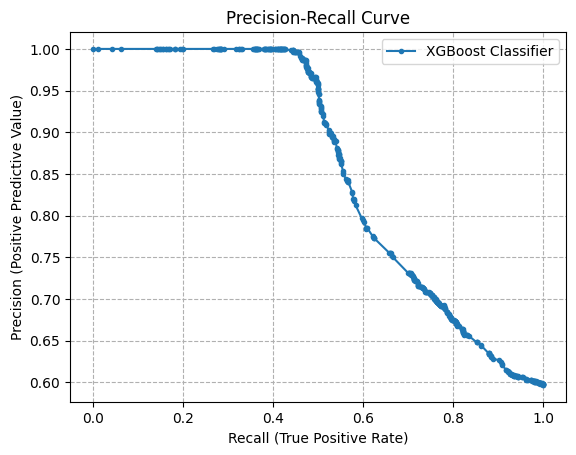

In [ ]:
precision, recall, thresholds = precision_recall_curve( y_test,y_scores )
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.grid(True, linestyle='--')

plt.legend()



In [ ]:
# Define your new optimal threshold
OPTIMAL_THRESHOLD = 0.477

# Convert probability scores (y_scores) into binary predictions (0 or 1)
# 1 if score >= threshold, else 0
y_pred_new = np.where(y_scores >= OPTIMAL_THRESHOLD, 1, 0)
new_recall = recall_score(y_test, y_pred_new)
new_precision = precision_score(y_test, y_pred_new)
new_cm = confusion_matrix(y_test, y_pred_new)
print('f1',f1_score(y_test, y_pred_new))
print('accuracy',accuracy_score(y_test, y_pred_new))
print('AUC',roc_auc_score(y_test,y_scores))


print(f"--- Performance at Threshold {OPTIMAL_THRESHOLD} ---")
print(f"New Recall:    {new_recall:.4f}")
print(f"New Precision: {new_precision:.4f}")
print(f"Confusion Matrix:\n{new_cm}")

f1 0.4163568773234201
accuracy 0.6035353535353535
AUC 0.6301381768312616
--- Performance at Threshold 0.477 ---
New Recall:    0.2875
New Precision: 0.7542
Confusion Matrix:
[[732  73]
 [555 224]]


In [ ]:
for i, item in enumerate(Tuned_xg.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

Prior_purchases: 0.19
Discount_offered: 0.40
Weight_in_gms: 0.10
Value_Density: 0.25
Cost_of_the_Product: 0.06


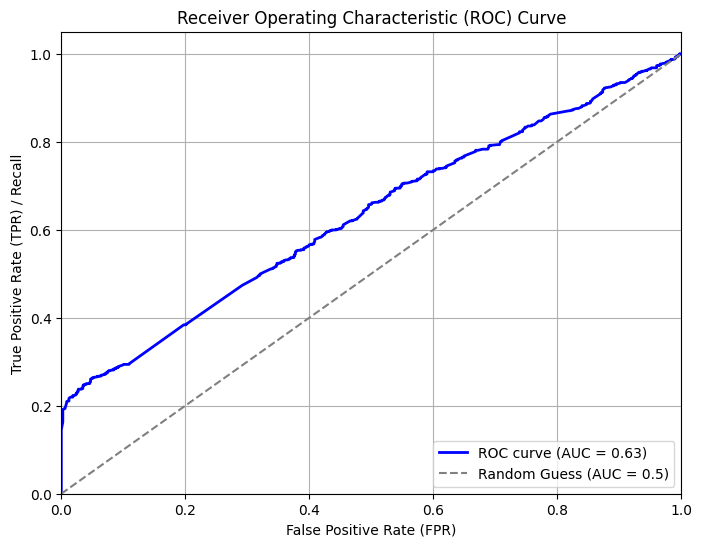

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = 0.63)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [139]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(sklearn.base.ClassifierMixin, XGBModel)
 |  XGBClassifier(
 |      *,
 |      objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
 |      **kwargs: Any
 |  ) -> None
 |
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |
 |  Parameters
 |  ----------
 |
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |
 |      max_depth :  typing.Optional[int]
 |
 |          Maximum tree depth for base learners.
 |
 |      max_leaves : typing.Optional[int]
 |
 |          Maximum number of leaves; 0 indicates no limit.
 |
 |      max_bin : typing.Optional[int]
 |
 |          If using histogram-based algorithm, maximum number of bins per feature
 |
 |      grow_policy : typing.Optional[str]
 |
 |          Tree growing policy.
 |